In [285]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [286]:
# df = pd.read_csv('~/downloads/fund_net_value_001594.csv')  # 银行
# df = pd.read_csv('~/downloads/fund_net_value_512500.csv')  # 中证500
# df = pd.read_csv('~/downloads/fund_net_value_000961.csv')  # 沪深300
# df = pd.read_csv('data/fund_net_value_001594.csv')  
# df = pd.read_csv('data/fund_net_value_512500.csv')  # 中证500
df = pd.read_csv('data/fund_net_value_000961.csv')  # 沪深300
df['day'] = pd.to_datetime(df['day'])
df = df.sort_values('day')

In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096 entries, 1095 to 0
Data columns (total 9 columns):
Unnamed: 0            1096 non-null int64
id                    1096 non-null int64
code                  1096 non-null int64
day                   1096 non-null datetime64[ns]
net_value             1096 non-null float64
sum_value             1096 non-null float64
factor                1096 non-null float64
acc_factor            1096 non-null float64
refactor_net_value    1096 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 85.6 KB


In [288]:
df.head()

,Unnamed: 0,id,code,day,net_value,sum_value,factor,acc_factor,refactor_net_value
1095,1095,5120066,961,2015-01-20,1.0000,1.0000,1.0,1.0,1.0000
1094,1094,3587494,961,2015-01-23,1.0332,1.0332,1.0,1.0,1.0332
1093,1093,3587495,961,2015-01-26,1.0416,1.0416,1.0,1.0,1.0416
1092,1092,3587496,961,2015-01-27,1.0357,1.0357,1.0,1.0,1.0357
1091,1091,3587497,961,2015-01-28,1.0297,1.0297,1.0,1.0,1.0297


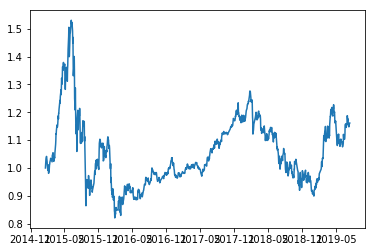

In [289]:
plt.plot(df['day'], df['sum_value'])

# 设置起止日期等全局变量

In [290]:
start_date = '20160101'
end_date = '20190710'

# 我自己计算的方法
- 把每期的投入都归到初始状态的present value，然后计算最后日期的future value，再处理无风险利率

In [291]:
from math import pow
buy_dates = pd.date_range(start=start_date, end=end_date, freq='5B')
invested = 0
returned = 0
for date in buy_dates:
#     invested += 100
    # with 无风险利率（或通货膨胀） as 4%, 折成初始日期的现值
    discount_rate = pow((1 + 0.00), (date - buy_dates[0]).days/365)
    invested += 100 / discount_rate
    while df[df['day']==date].empty:  # 如果是春节或者国庆的节假日，延后算这笔投资
        date += 1
    shares = 100 / float(df[df['day']==date]['sum_value'])
    returned += shares * float(df[df['day']==end_date]['sum_value'])
print("Invested money is: {0:.2f}".format(invested))
print("Returned money is: {0:.2f}".format(returned))
total_return = (returned - invested) / invested
print("The total return is: {0:.2%}".format(total_return))
years_passed = (buy_dates[-1] - buy_dates[0]).days / 365
annual_return = total_return / years_passed
print("The annual return is: {0:.2%}".format(annual_return))
print("The risk premium compared to no-risk assets: {0:.2%}".format(annual_return - 0.04))

Invested money is: 18400.00
Returned money is: 20599.43
The total return is: 11.95%
The annual return is: 3.41%
The risk premium compared to no-risk assets: -0.59%


In [292]:
curr_value = df[df['day']==end_date]['sum_value']
position = len(df[df['sum_value'] < curr_value.values[0]]) / len(df)
print(position)

0.7855839416058394


In [293]:
df.reset_index(inplace=True)

In [294]:
df.head()

,index,Unnamed: 0,id,code,day,net_value,sum_value,factor,acc_factor,refactor_net_value
0,1095,1095,5120066,961,2015-01-20,1.0000,1.0000,1.0,1.0,1.0000
1,1094,1094,3587494,961,2015-01-23,1.0332,1.0332,1.0,1.0,1.0332
2,1093,1093,3587495,961,2015-01-26,1.0416,1.0416,1.0,1.0,1.0416
3,1092,1092,3587496,961,2015-01-27,1.0357,1.0357,1.0,1.0,1.0357
4,1091,1091,3587497,961,2015-01-28,1.0297,1.0297,1.0,1.0,1.0297


In [295]:
'''一个简单的策略，在历史价格区间的下50%就买入，上50%不买（后续可以设计高于70%就卖出，可以一次性也可以陆续卖出）'''
from math import pow
buy_dates = pd.date_range(start=start_date, end=end_date, freq='5B')
invested = 0
returned = 0
for date in buy_dates:
#     invested += 100
    # with 无风险利率（或通货膨胀） as 4%, 折成初始日期的现值
    while df[df['day']==date].empty:  # 如果是春节或者国庆的节假日，延后算这笔投资
        date += 1
    curr_idx = df[df['day']==date].index[0]
    mid_value = df.iloc[0:curr_idx, :]['sum_value'].median()
    if float(df[df['day']==date]['sum_value']) < mid_value:
        discount_rate = pow((1 + 0.04), (date - buy_dates[0]).days/365)
        invested += 100 / discount_rate
        shares = 100 / float(df[df['day']==date]['sum_value'])
        returned += shares * float(df[df['day']==end_date]['sum_value'])
print("Invested money is: {0:.2f}".format(invested))
print("Returned money is: {0:.2f}".format(returned))
total_return = (returned - invested) / invested
print("The total return is: {0:.2%}".format(total_return))
years_passed = (buy_dates[-1] - buy_dates[0]).days / 365
annual_return = total_return / years_passed
print("The annual return is: {0:.2%}".format(annual_return))
print("The risk premium compared to no-risk assets: {0:.2%}".format(annual_return - 0.04))

Invested money is: 8072.03
Returned money is: 10301.85
The total return is: 27.62%
The annual return is: 7.87%
The risk premium compared to no-risk assets: 3.87%


In [296]:
import numpy as np

In [297]:
np.irr([-10, -10, -10, 21])

-0.16803256325411353

# 使用xirr

In [298]:
import datetime
from scipy import optimize
 
# # 函数
# def xnpv(rate, cashflows):
#     return sum([cf/(1+rate)**((t-cashflows[0][0]).days/365.0) for (t,cf) in cashflows])
 
# def xirr(cashflows, guess=0.1):
#     try:
#         return optimize.newton(lambda r: xnpv(r,cashflows),guess)
#     except:
#         print('Calc Wrong')

from datetime import date
 
# 函数
def xirr(cashflows):
    years = [(ta[0] - cashflows[0][0]).days / 365. for ta in cashflows]
    residual = 1.0
    step = 0.05
    guess = 0.05
    epsilon = 0.0001
    limit = 10000
    while abs(residual) > epsilon and limit > 0:
        limit -= 1
        residual = 0.0
        for i, trans in enumerate(cashflows):
            residual += trans[1] / pow(guess, years[i])
        if abs(residual) > epsilon:
            if residual > 0:
                guess += step
            else:
                guess -= step
                step /= 2.0
    return guess - 1

In [299]:
# 测试
data = [(datetime.date(2006, 1, 24), -39967), 
        (datetime.date(2008, 2, 6), -19866), 
        (datetime.date(2010, 10, 18), 245706), 
        (datetime.date(2013, 9, 14), 52142)]
xirr(data)

0.42369774132967053

In [300]:
'''每期必投的傻瓜策略'''
# 单位净值有可能高于累计净值，因为折算的关系，就是share的数量变少了，价格变贵，为了追踪指数什么的
buy_dates = pd.date_range(start=start_date, end=end_date, freq='5B')
invested = 0
shares = 0
investment_records = []
for date in buy_dates:
    while df[df['day']==date].empty:  # 如果是春节或者国庆的节假日，延后算这笔投资
        date += 1
    investment_records.append((date, -100))
    shares += 100 / float(df[df['day']==date]['sum_value'])
investment_records.append((pd.to_datetime(end_date), shares * float(df[df['day']==end_date]['sum_value'])))

print("Invested money is: {0:.2f}".format(-sum([money for (date, money) in investment_records[:-1]])))
print("Returned money is: {0:.2f}".format(investment_records[-1][1]))
print("The annual return is: {0:.2%}".format(xirr(investment_records)))

Invested money is: 18400.00
Returned money is: 20599.43
The annual return is: 6.48%


In [301]:
xirr(investment_records)

0.06475414037704463

In [302]:
'''一个简单的策略，在历史价格区间的下50%就买入，上50%不买（后续可以设计高于70%就卖出，可以一次性也可以陆续卖出）'''
buy_dates = pd.date_range(start=start_date, end=end_date, freq='5B')
invested = 0
shares = 0
investment_records = []
for date in buy_dates:
    while df[df['day']==date].empty:  # 如果是春节或者国庆的节假日，延后算这笔投资
        date += 1
    curr_idx = df[df['day']==date].index[0]
    mid_value = df.iloc[0:curr_idx, :]['sum_value'].median()
    if float(df[df['day']==date]['sum_value']) < mid_value:
        investment_records.append((date, -100))
        shares += 100 / float(df[df['day']==date]['sum_value'])
investment_records.append((pd.to_datetime(end_date), shares * float(df[df['day']==end_date]['sum_value'])))

print("Invested money is: {0:.2f}".format(-sum([money for (date, money) in investment_records[:-1]])))
print("Returned money is: {0:.2f}".format(investment_records[-1][1]))
print("The annual return is: {0:.2%}".format(xirr(investment_records)))

Invested money is: 8500.00
Returned money is: 10301.85
The annual return is: 8.98%


In [303]:
'''一个简单的策略，在历史价格区间的下50%就买入，高于70%就卖出，陆续卖出吧，每次卖出价值100元的份额'''
buy_dates = pd.date_range(start=start_date, end=end_date, freq='5B')
invested = 0
shares = 0
investment_records = []
for date in buy_dates:
    while df[df['day']==date].empty:  # 如果是春节或者国庆的节假日，延后算这笔投资
        date += 1
    curr_idx = df[df['day']==date].index[0]
    mid_value = df.iloc[0:curr_idx, :]['sum_value'].quantile(0.5)
    if float(df[df['day']==date]['sum_value']) < mid_value:
        investment_records.append((date, -100))
        shares += 100 / float(df[df['day']==date]['sum_value'])
    elif float(df[df['day']==date]['sum_value']) > df.iloc[0:curr_idx, :]['sum_value'].quantile(0.7):
        if investment_records[-1][1] > 100:
            investment_records.append((date, 100))
            shares -= 100 / float(df[df['day']==date]['sum_value'])
        
investment_records.append((pd.to_datetime(end_date), shares * float(df[df['day']==end_date]['sum_value'])))

print("Invested money is: {0:.2f}".format(-sum([money for (date, money) in investment_records if money < 0])))
print("Returned money is: {0:.2f}".format(sum([money for (date, money) in investment_records if money > 0])))
print("The annual return is: {0:.2%}".format(xirr(investment_records)))

Invested money is: 8500.00
Returned money is: 10301.85
The annual return is: 8.98%
